# Import packages and Mount Google Drive

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Albumentation library is used to stabilise contrast with CLAHE
# !pip3 install -U albumentations
# !pip3 install --upgrade opencv-python

In [4]:
# Gdrive mounting 
import sys, os
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount("/content/gdrive")
  path_to_file = '/content/gdrive/MyDrive/' # change accordingly
  os.chdir(path_to_file)
  os.getcwd()
  print("Finished mounting drive.")

Mounted at /content/gdrive
Finished mounting drive.


# Gabor Filters

Band pass filter, general formula is given by: 
$$g(x, y; λ, θ, ϕ, σ, γ) = \exp\bigg(-\frac{x'^2 + γ^2y'^2}{2σ^2}\bigg)\exp\bigg(i\bigg(2\pi\frac{x'}{λ}+ϕ\bigg)\bigg)$$ 

where $x' = x \cos \theta + y \sin \theta$ and $y' = -x \sin \theta + y \cos \theta$

- $\lambda$  represents the wavelength of the sinusoidal factor
- $\theta$  represents the orientation of the normal to the parallel stripes of a Gabor function
- $\psi$  is the phase offset
- $\sigma$  is the sigma/standard deviation of the Gaussian envelope
- $\gamma$  is the spatial aspect ratio, and specifies the ellipticity of the support of the Gabor function.

In [9]:
# Visualization, change parameters to see changes to filter
ksize = 20
sigma = 3
theta = 3*np.pi/4
lambd = 1*np.pi/2
gamma = 0.01
phi = 0

In [5]:
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)

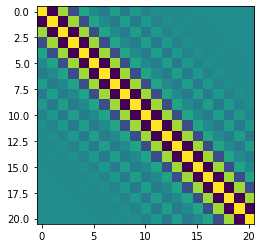

In [6]:
plt.imshow(kernel)

In [8]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 12
    ksize = 20  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.1
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [13]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [11]:
# Image we are using
img = cv2.imread("example.jpg")

# # Pipeline for CLAHE (reduces noise during edge detection)
# equalize = A.Compose([
#                       A.CLAHE(p=1),
# ])
# equalized = equalize(image=img)
# img = equalized["image"]

In [18]:
gfilters = create_gaborfilter()
img_g = apply_filter(img, gfilters)

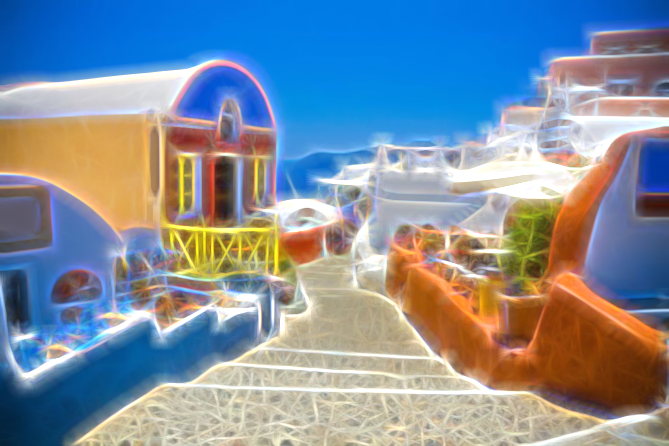

In [19]:
cv2_imshow(img_g)

In [20]:
# Let us see the difference in edges using the Canny algorithm
img_canny = cv2.Canny(img, 100, 255)
img_g_canny = cv2.Canny(img_g, 100, 255)

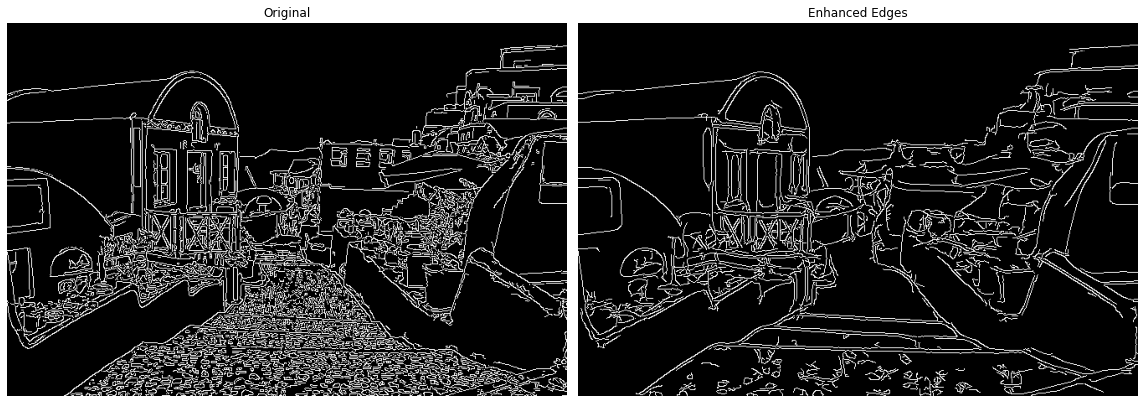

In [22]:
# Visualization
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(16, 14))

axes[0].imshow(img_canny, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(img_g_canny, cmap=plt.cm.gray)
axes[1].set_title('Enhanced Edges')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()